# Clustering der männlichen Beobachtungen

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier

In [2]:
heartData = pd.read_csv("heart-failure-prediction/heart.csv")
heartData.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
# Entfernen unangegebener Cholersterin Beobachtungen und Frauen
heartData = heartData[(heartData["Sex"] != "F") & (heartData["Cholesterol"] != 0)]
heartData = heartData.drop(columns=["ST_Slope" ,"RestingECG", "ChestPainType", "ExerciseAngina", "FastingBS"])
heartData.head()

,Age,Sex,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease
0,40,M,140,289,172,0.0,0
2,37,M,130,283,98,0.0,0
4,54,M,150,195,122,0.0,0
5,39,M,120,339,170,0.0,0
7,54,M,110,208,142,0.0,0


## Ausreißer Entfernung

In [4]:
#Entfernen von Cholesterin
q1 = heartData['Cholesterol'].quantile(0.25)
q3 = heartData['Cholesterol'].quantile(0.75)
iqr = q3-q1
upper_limit = q3 + (1.5 * iqr)
lower_limit = q1 - (1.5 * iqr)
# trimming - delete the outlier data
new_df = heartData.loc[(heartData['Cholesterol'] <= upper_limit) & (heartData['Cholesterol'] >= lower_limit)]
heartData = new_df.copy()

# Entfernen von RestingBP
q1 = heartData['RestingBP'].quantile(0.25)
q3 = heartData['RestingBP'].quantile(0.75)
iqr = q3-q1
upper_limit = q3 + (1.5 * iqr)
lower_limit = q1 - (1.5 * iqr)
# trimming - delete the outlier data
new_df = heartData.loc[(heartData['RestingBP'] <= upper_limit) & (heartData['RestingBP'] >= lower_limit)]
heartData = new_df.copy()

new_df = heartData.loc[(heartData['Oldpeak'] <= 4)]
heartData = new_df.copy()


## Umwandlung in nummerische Werte

In [5]:
# Umwandlung der Spalte "Sex" in nummerischen Wert
heartData["Sex"] = heartData["Sex"].apply(lambda x: 0 if x == "M" else 1)

## Klassifizierung

In [6]:
heartData['label'] = 0
heartData

,Age,Sex,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,label
0,40,0,140,289,172,0.0,0,0
2,37,0,130,283,98,0.0,0,0
4,54,0,150,195,122,0.0,0,0
5,39,0,120,339,170,0.0,0,0
7,54,0,110,208,142,0.0,0,0
...,...,...,...,...,...,...,...,...
911,59,0,164,176,90,1.0,1,0
913,45,0,110,264,132,1.2,1,0
914,68,0,144,193,141,3.4,1,0
915,57,0,130,131,115,1.2,1,0


### Person mit ungesunden Cholesterinspiegel

In [7]:
cholesterolPersons = heartData.query("240 <= Cholesterol <= 603").copy()
cholesterolPersons = cholesterolPersons.query("100 <= RestingBP <= 130")
cholesterolPersons = cholesterolPersons.query("100 <= MaxHR <= 140")
#cholesterolPersons = cholesterolPersons.query("FastingBS == 0")

heartData.loc[cholesterolPersons.index, 'label'] = 1

### Personen mit Bluthochdruck

In [8]:
highBloodPressurePersons = heartData.query("200 <= Cholesterol <= 240")
highBloodPressurePersons = highBloodPressurePersons.query("130 <= RestingBP <= 200")
highBloodPressurePersons = highBloodPressurePersons.query("100 <= MaxHR <= 140")
#highBloodPressurePersons = highBloodPressurePersons.query("FastingBS == 0")

heartData.loc[highBloodPressurePersons.index, 'label'] = 2

### Personen mit zu hoher Herzfrequenz

In [9]:
HRPersons = heartData.query("200 <= Cholesterol <= 240")
HRPersons = HRPersons.query("100 <= RestingBP <= 130")
HRPersons = HRPersons.query("140 <= MaxHR <= 202")
#HRPersons = HRPersons.query("FastingBS == 0")

heartData.loc[HRPersons.index, 'label'] = 3

## Clustering

In [10]:
# Nummerische und Kategorie Attribute rausfiltern
numericFeatures = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
numericHeartData = heartData.loc[:,numericFeatures].copy()

Text(0.5, 1.0, 'Korrelationskoeffizienten')

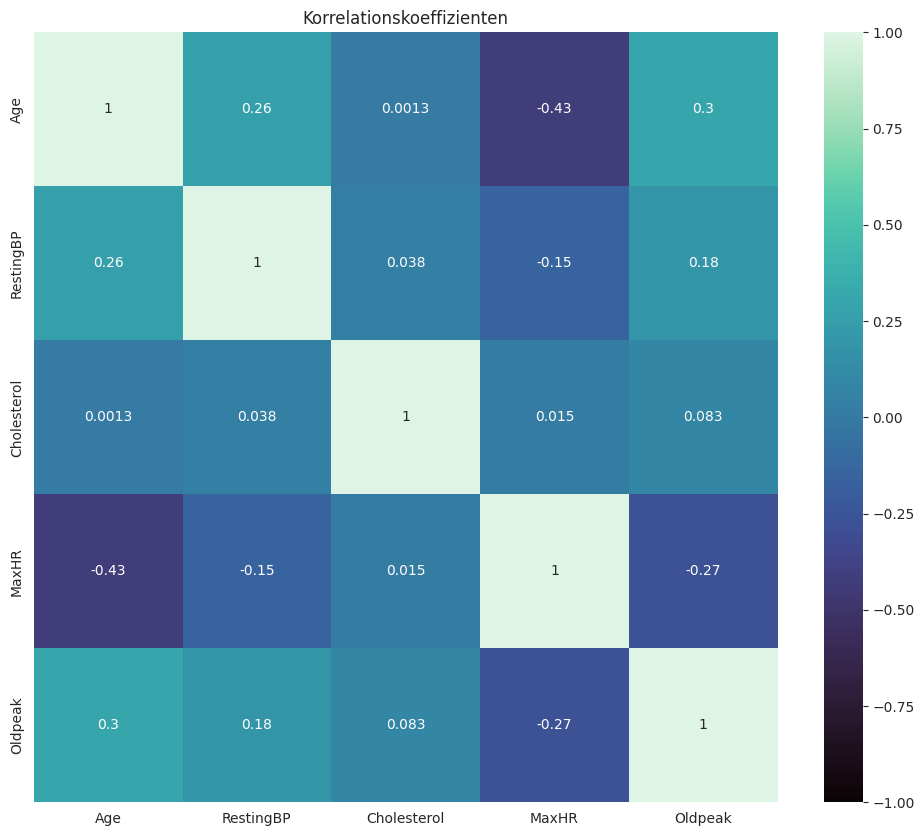

In [11]:
correlations = numericHeartData.corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlations, annot=True, vmin=-1.0, cmap="mako")

plt.title("Korrelationskoeffizienten")

## Standardisierung

In [12]:
y = heartData["HeartDisease"]
x = heartData.drop("HeartDisease", axis=1).copy()
x = x.drop("label", axis=1).copy()
x = x.drop("Sex", axis=1).copy()

# Skalieren
StandardScaler = pd.DataFrame(StandardScaler().fit_transform(x), columns=x.columns)
minMax = pd.DataFrame(MinMaxScaler().fit_transform(x), columns=x.columns)
robustScaler = pd.DataFrame(RobustScaler().fit_transform(x), columns=x.columns)

## Visualisierung

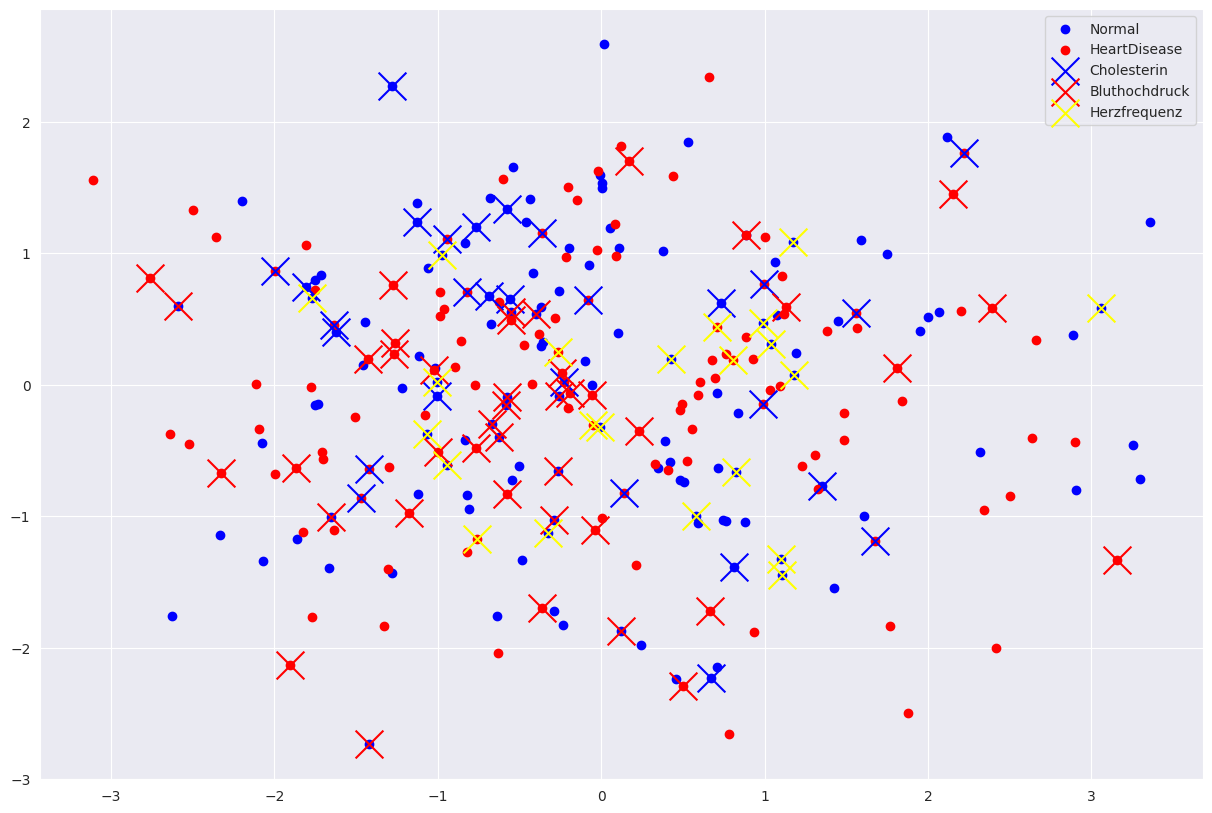

In [13]:
pca = PCA(n_components=2)
reduced_x = pd.DataFrame(pca.fit_transform(StandardScaler), columns=["PC1","PC2"])
reduced_x["HeartDisease"] = heartData["HeartDisease"]
reduced_x["label"] = heartData["label"]

plt.figure(figsize=(15,10))

plt.scatter(reduced_x[reduced_x["HeartDisease"] == 0]["PC1"],reduced_x[reduced_x["HeartDisease"] == 0]["PC2"], color = "blue", label="Normal")
plt.scatter(reduced_x[reduced_x["HeartDisease"] == 1]["PC1"],reduced_x[reduced_x["HeartDisease"] == 1]["PC2"], color = "red", label="HeartDisease")

plt.scatter(reduced_x[reduced_x["label"] == 1]["PC1"],reduced_x[reduced_x["label"] == 1]["PC2"], color = "blue", marker = "x", label="Cholesterin", s =400)
plt.scatter(reduced_x[reduced_x["label"] == 2]["PC1"],reduced_x[reduced_x["label"] == 2]["PC2"], color = "red", marker = "x", label="Bluthochdruck", s =400)
plt.scatter(reduced_x[reduced_x["label"] == 3]["PC1"],reduced_x[reduced_x["label"] == 3]["PC2"], color = "yellow", marker = "x", label="Herzfrequenz", s =400)

plt.legend()
plt.savefig("PNG/standardPCA.png")
plt.show()

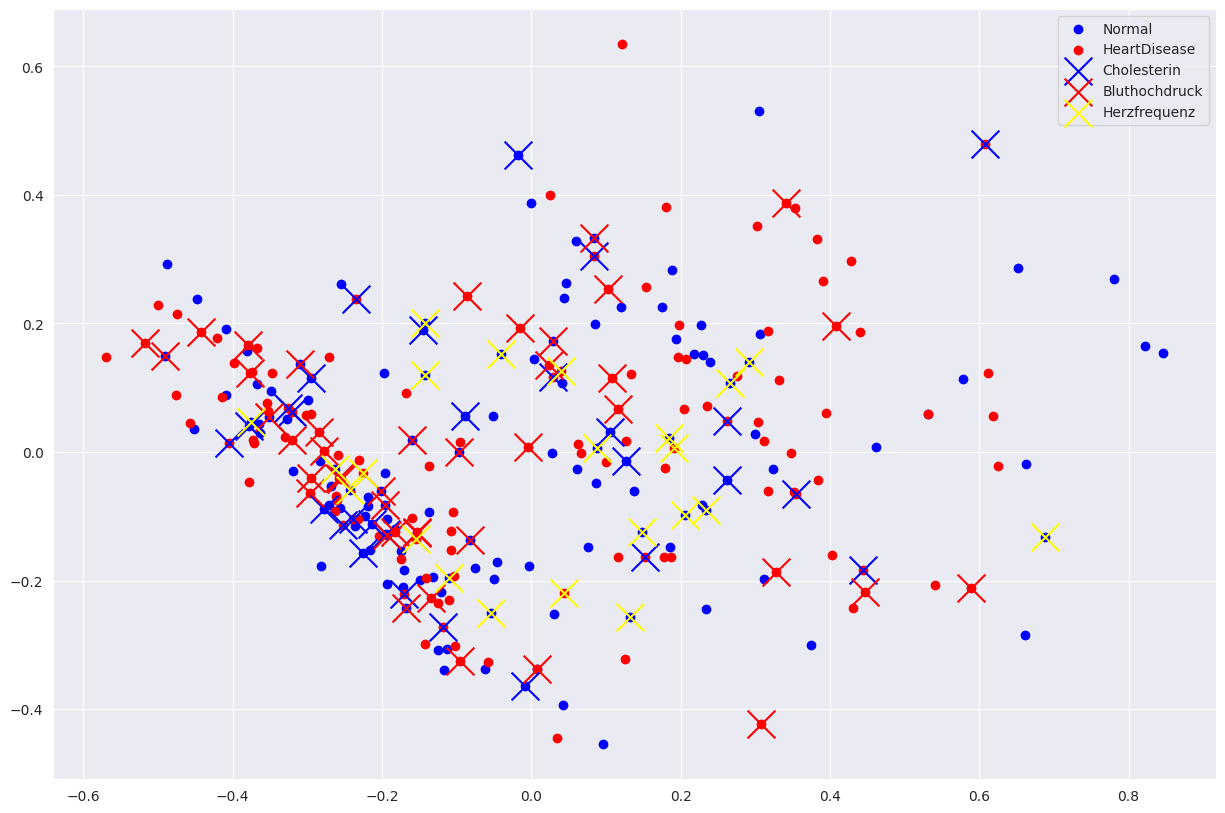

In [14]:
pca = PCA(n_components=2)
reduced_x = pd.DataFrame(pca.fit_transform(minMax), columns=["PC1","PC2"])
reduced_x["HeartDisease"] = heartData["HeartDisease"]
reduced_x["label"] = heartData["label"]

plt.figure(figsize=(15,10))

plt.scatter(reduced_x[reduced_x["HeartDisease"] == 0]["PC1"],reduced_x[reduced_x["HeartDisease"] == 0]["PC2"], color = "blue", label="Normal")
plt.scatter(reduced_x[reduced_x["HeartDisease"] == 1]["PC1"],reduced_x[reduced_x["HeartDisease"] == 1]["PC2"], color = "red", label="HeartDisease")

plt.scatter(reduced_x[reduced_x["label"] == 1]["PC1"],reduced_x[reduced_x["label"] == 1]["PC2"], color = "blue", marker = "x", label="Cholesterin", s =400)
plt.scatter(reduced_x[reduced_x["label"] == 2]["PC1"],reduced_x[reduced_x["label"] == 2]["PC2"], color = "red", marker = "x", label="Bluthochdruck", s =400)
plt.scatter(reduced_x[reduced_x["label"] == 3]["PC1"],reduced_x[reduced_x["label"] == 3]["PC2"], color = "yellow", marker = "x", label="Herzfrequenz", s =400)

plt.legend()
plt.savefig("PNG/minMaxPCA.png")
plt.show()

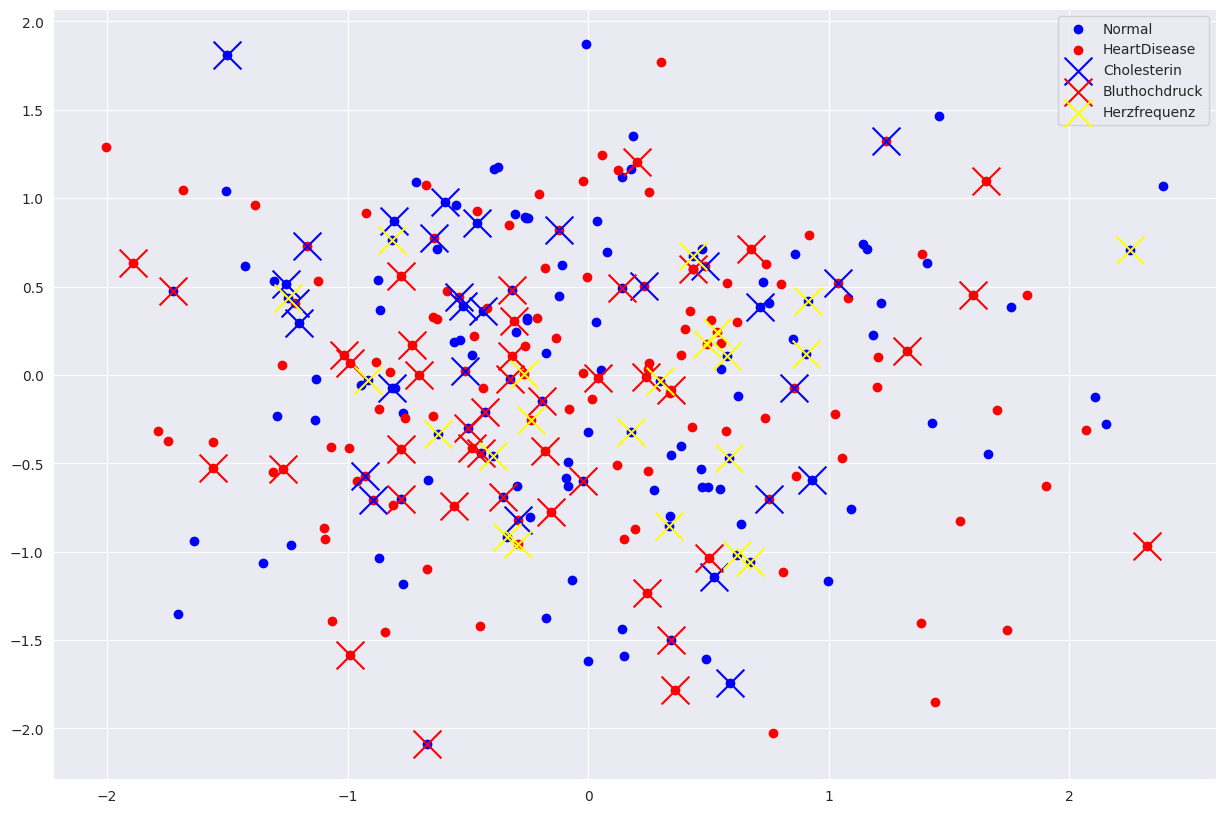

In [15]:
pca = PCA(n_components=2)
reduced_x = pd.DataFrame(pca.fit_transform(robustScaler), columns=["PC1","PC2"])
reduced_x["HeartDisease"] = heartData["HeartDisease"]
reduced_x["label"] = heartData["label"]

plt.figure(figsize=(15,10))

plt.scatter(reduced_x[reduced_x["HeartDisease"] == 0]["PC1"],reduced_x[reduced_x["HeartDisease"] == 0]["PC2"], color = "blue", label="Normal")
plt.scatter(reduced_x[reduced_x["HeartDisease"] == 1]["PC1"],reduced_x[reduced_x["HeartDisease"] == 1]["PC2"], color = "red", label="HeartDisease")

plt.scatter(reduced_x[reduced_x["label"] == 1]["PC1"],reduced_x[reduced_x["label"] == 1]["PC2"], color = "blue", marker = "x", label="Cholesterin", s =400)
plt.scatter(reduced_x[reduced_x["label"] == 2]["PC1"],reduced_x[reduced_x["label"] == 2]["PC2"], color = "red", marker = "x", label="Bluthochdruck", s =400)
plt.scatter(reduced_x[reduced_x["label"] == 3]["PC1"],reduced_x[reduced_x["label"] == 3]["PC2"], color = "yellow", marker = "x", label="Herzfrequenz", s =400)

plt.legend()
plt.savefig("PNG/robustPCA.png")
plt.show()

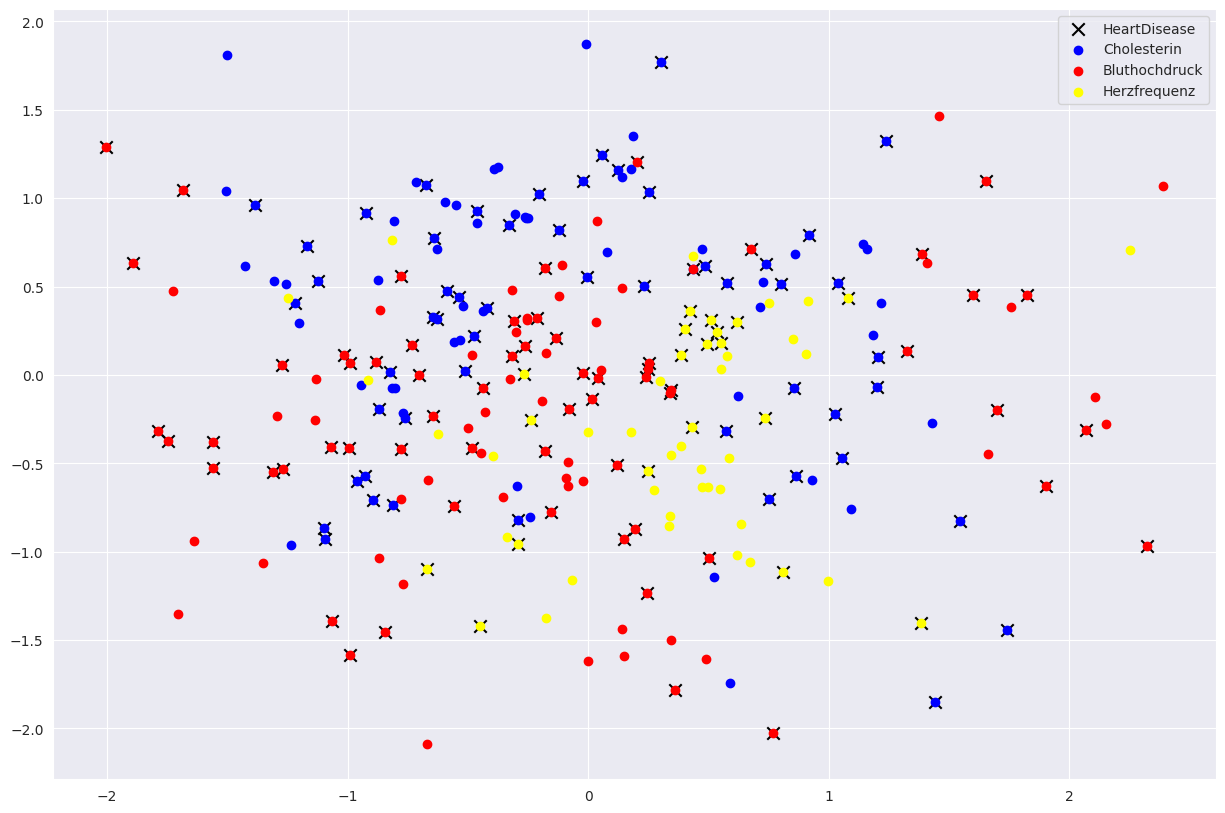

In [16]:
pca = PCA(n_components=2)
reduced_x = pd.DataFrame(pca.fit_transform(robustScaler), columns=["PC1","PC2"])
reduced_x["HeartDisease"] = heartData["HeartDisease"]
reduced_x["label"] = heartData["label"]

# Trainingsdaten für den kNN-Klassifikator
training_data = reduced_x[reduced_x["label"].isin([1, 2, 3, 4])]
X_train = training_data[["PC1", "PC2"]]
y_train = training_data["label"]

# Daten zum Klassifizieren (Klasse 0)
classify_data = reduced_x[reduced_x["label"] == 0]
X_classify = classify_data[["PC1", "PC2"]]

# KNN-Klassifikator erstellen und trainieren
knn_classifier = KNeighborsClassifier(n_neighbors=3)  # Anpassen der Anzahl der Nachbarn nach Bedarf
knn_classifier.fit(X_train, y_train)

# Vorhersagen für die Klasse 0 machen
predictions = knn_classifier.predict(X_classify)

# Ergebnisse in reduced_x einfügen
reduced_x.loc[reduced_x["label"] == 0, "label"] = predictions

# Plot mit den aktualisierten Labels
plt.figure(figsize=(15, 10))
plt.scatter(reduced_x[reduced_x["HeartDisease"] == 1]["PC1"],reduced_x[reduced_x["HeartDisease"] == 1]["PC2"], color = "black", marker = "x", label="HeartDisease", s=80)

plt.scatter(reduced_x[reduced_x["label"] == 1]["PC1"],reduced_x[reduced_x["label"] == 1]["PC2"], color = "blue", marker = "o", label="Cholesterin")
plt.scatter(reduced_x[reduced_x["label"] == 2]["PC1"],reduced_x[reduced_x["label"] == 2]["PC2"], color = "red", marker = "o", label="Bluthochdruck")
plt.scatter(reduced_x[reduced_x["label"] == 3]["PC1"],reduced_x[reduced_x["label"] == 3]["PC2"], color = "yellow", marker = "o", label="Herzfrequenz")

plt.legend()
plt.savefig("PNG/finalPCA.png")
plt.show()